## Problem Statement
- Cluster data points using `k-means`; implement own k-means algorithm.
- Apply clustering on iris dataset (_provided_) with assumption `k=3`, else perform a hyperparameter search.
- Demonstrate the results with applying `k-means` for norms
    - L1 (_Manhattan Distance_)
    - L2 (_Euclidean Distance_)
- Custom `k-means` must allow inputs
    - __k__: number if clusters
    - __norm__: norm to use for distance meassure (_L1, L2_)
 
### Deliver (User hyperlinks to jump to part of solution)
 - [x] Final Code
 - [x] Train the model using both norms (_[L1](#Use-L1-Norm), [L2](#Use-L2-Norm)_)
 - [x] [Hyperparameter Tuning](#Hyperparameter-Tuning)
 - [x] Submit CSV with predicted classification columns, ([Train Set](#Write-Train-Classification-Labels-to-CSV), [Test Set](#Write-Test-Classification-Labels-to-CSV))
 - [x] Plot graphs in multivariate space, color coded on basis of classification, (_[L1](#Use-L1-Norm), [L2](#Use-L2-Norm)_)
 - [x] [Provide classification metric on test data](#Explanation)
 - [x] [Custom KMeans to be able to run on arbirtary dataset](#Flexibility-of-Custom-KMeans) (_`Note: consumes considerable time to tune hyperparameters`_)

## Assignment Information
- This assignment was done using docker container.
- In order to play with Jupyter Notebook, launch docker container with command provided below.
- Start Jupyter container, (_please be sure to be in same directory as the assignment_)
    ```
    docker run --rm --name ds-notebook -v $(pwd):~/work jupyter/scipy-notebook:6d42503c684f
    ```
    
### Solution Files
- __custom_kmeans.py__: Implementation of kmeans
- __extmath.py__: Mathematical functions necessary for kmeans
- __kmeans_assignment.ipynb__: Ipython notebook contains __Deliverables__ and the use of custom kmeans algorithm.
- __kmeans_assignment.html__: contains __Deliverables__ and the use of custom kmeans algorithm (_generated from notebook_)
- __output...___: files for graphs and csv generated, part of solution

### References
- https://stanford.edu/~cpiech/cs221/handouts/kmeans.html
- https://bradleyboehmke.github.io/HOML/kmeans.html#determine-k
- https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
- https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a6


## Initial Setup

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import numpy as np
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('ggplot')
print('Setup Complete.')

Setup Complete.


In [2]:
# Column headers missing, use index=range(dimension)
dimension = 4
# number of clusters
k = 3
# filename to output model classification labels
CLASSIFICATION_TRAIN_CSV = 'output_iris_train_kmeans_classification_labels.csv'
CLASSIFICATION_TEST_CSV = 'output_iris_test_kmeans_classification_labels.csv'

In [3]:
iris = pd.read_csv('./iris_train.csv', names=list(range(dimension+1)))
print('Data load complete.')

Data load complete.


## Data Surfing

In [4]:
iris.head()

,0,1,2,3,4
0,7.2,3.2,6.0,1.8,Iris-virginica
1,6.3,3.3,4.7,1.6,Iris-versicolor
2,6.3,3.3,6.0,2.5,Iris-virginica
3,5.0,3.5,1.3,0.3,Iris-setosa
4,5.9,3.0,5.1,1.8,Iris-virginica


- Data is loaded as expected
- We will use columns [0,1,2,3] for clustering and column [4] (_class labels_) will be used later to compute classification score.

In [5]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       130 non-null    float64
 1   1       130 non-null    float64
 2   2       130 non-null    float64
 3   3       130 non-null    float64
 4   4       130 non-null    object 
dtypes: float64(4), object(1)
memory usage: 5.2+ KB


- Columns [0..3] have all `non-null` values, no Imputation is required.
- Also, we can see below Column [4] has 3 unique values `['Iris-virginica', 'Iris-versicolor', 'Iris-setosa']`, hence assumption made before about number of clusters (_`k=3`_) seems fair.

In [6]:
iris[4].unique()

array(['Iris-virginica', 'Iris-versicolor', 'Iris-setosa'], dtype=object)

In [7]:
iris.describe()

,0,1,2,3
count,130.000000,130.000000,130.000000,130.000000
mean,5.845385,3.032308,3.823077,1.228462
std,0.818877,0.434592,1.733909,0.746904
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.400000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


- Class labels will be later used to get accuracy score by mapping cluster labels to class.
- Train samples should be standardized to better fit the clustering.

## Data Visualization

In [8]:
# Helper function to color code cluster labels.
color_labels = {'purple': 0, '#3498DB': 1, '#F39C12': 2}
def color3c(labels):
    clr = []
    for label in labels:
        for c, l in color_labels.items():
            if l == label:
                clr.append(c)
    if len(clr) != len(labels):
        raise ValueError(f'colors decided only for labels {color_labels.values()}')
    return clr

In [9]:
X, y = iris.drop(iris.columns[-1], axis=1), iris[iris.columns[-1]]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe92e320160>,
      dtype=object)

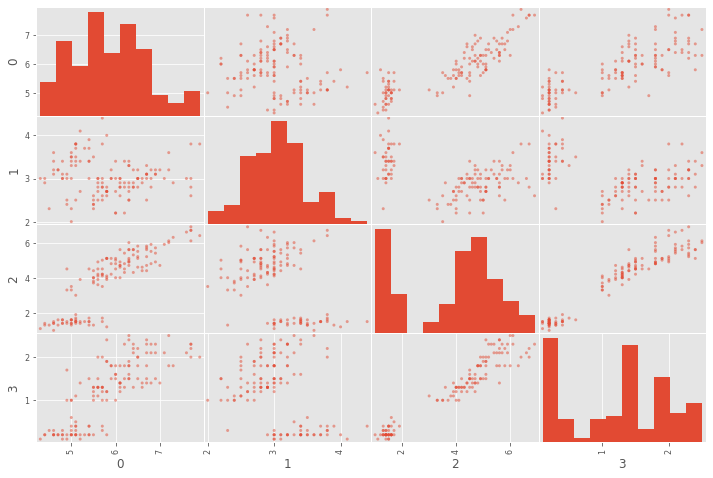

In [10]:
%matplotlib inline
from pandas.plotting import scatter_matrix
scatter_matrix(X, figsize=(12,8))

- Columns [0,1] show guassian distribution, while Columns [2,3] does not.
- `Dataset should be standardized to improve clustering`
- Column [2,3] show high correlation, can be reduced to single column using dimensionality reduction.
- Columns [2] data is not contiguous

In [11]:
# Reducing train data to 3 dimensions for visualizing in 3D.
pca = PCA(n_components=3, random_state=42)
pca.fit(X)
print(f'Dimension reduction with variance ratio: {pca.explained_variance_ratio_.sum()}')

Dimension reduction with variance ratio: 0.9948783992481702


In [12]:
X_pca_3d = pca.transform(X)

In [13]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

y_encoded = encoder.fit_transform(y)

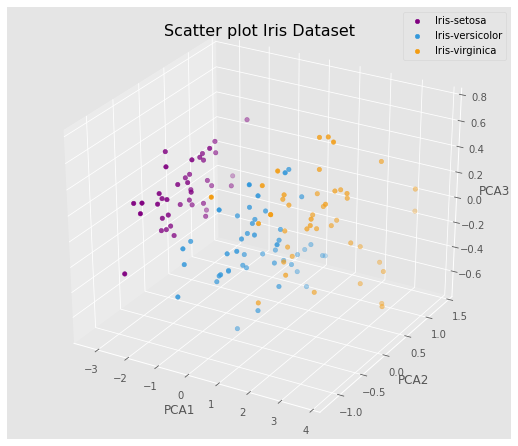

In [14]:
fig = plt.figure(figsize=(7, 6))

ax = Axes3D(fig)

xs = X_pca_3d[:, 0]
ys = X_pca_3d[:, 1]
zs = X_pca_3d[:, 2]

for i in range(k):
    idx = y_encoded==i
    color = color3c(np.unique(y_encoded[idx]))
    class_label = y[idx].unique()[0]
    ax.scatter(xs[idx], ys[idx], zs[idx], marker='o', s=20, c=color, label=class_label)

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.legend()

plt.title('Scatter plot Iris Dataset', fontsize=16)
plt.show()

- Given `Iris` dataset has 4 dimensions, in order to visualize in 3D space we reduced data to 3 dimensions (_dimension reduction_) with `high variance (> 99%) intact`.
- Also, used the class labels provided in dataset to show the sample_inputs color coded (_had to label encode class labels_).
- There are no well defined cluster boundaries in scatter plot (_hard to detect_).
- There are some outliers in dataset (_kmeans is sensitive to outliers_)
- Note: `Better to use StandardScaler for data processing, cause it's less affected by outliers`

## Data Preprocessing

In [15]:
X, y = iris.drop(iris.columns[-1], axis=1), iris[iris.columns[-1]]

In [16]:
preprocessing_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('stdscaler', StandardScaler()),
    ('pca', PCA(n_components=3, random_state=42))
])

In [17]:
X_processed = pd.DataFrame(preprocessing_pipe.fit_transform(X))
X_processed.describe()

,0,1,2
count,1.300000e+02,130.000000,1.300000e+02
mean,-1.024821e-17,0.000000,1.014146e-17
std,1.698801e+00,0.983452,3.964453e-01
min,-2.858213e+00,-2.610438,-8.965593e-01
25%,-2.109303e+00,-0.611059,-2.732150e-01
50%,3.537063e-01,-0.027898,3.529283e-02
75%,1.211727e+00,0.603755,2.268588e-01
max,3.294665e+00,2.813619,1.003339e+00


- Even though there is no missing values in dataset, still add `Imputation transformer` to complete missing values.
- Imputation strategy set to `mean` (_data distribution follows guassian curve for Columns [0,1], `will further test strategy in hyperparameter tuning`_)
- Data is more standardized (`std ~= 1`)
- Data dimensionality is reduced to ease the case of visualizaiton of results (_also as shown, reduction still keeps variance intact above 99%_)

## Train Model

### Use L2 Norm

In [18]:
from custom_kmeans import KMeans
kmeans = KMeans(n_clusters=k, init='random', norm_=2, tol=1e-4, random_state=42)
kmeans_l2_pipeline = Pipeline([
    ('preprocess', preprocessing_pipe),
    ('kmeans', kmeans)
])

In [19]:
X, y = iris.drop(iris.columns[-1], axis=1), iris[iris.columns[-1]]
kmeans_l2_pipeline.fit(X)

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('stdscaler', StandardScaler()),
                                 ('pca',
                                  PCA(n_components=3, random_state=42))])),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

In [20]:
X_processed = preprocessing_pipe.fit_transform(X)
l1_inertia = kmeans_l2_pipeline['kmeans'].distance_from_center(X_processed, norm_=1, squared=True)
predict_class, cl_mapping = kmeans_l2_pipeline['kmeans'].map_cluster_class(y)

print('KMeans results on training set with norm=L2')
print('_'*80)
print(f'Cluster Centers: ',kmeans_l2_pipeline['kmeans'].cluster_centers_)
print('-'*80)
print(f"Inertia (L2/L1): ({kmeans_l2_pipeline['kmeans'].inertia_}/{l1_inertia})")
print('-'*80)
print(f'Silhouette Score: ', silhouette_score(X_processed, kmeans_l2_pipeline['kmeans'].labels_))
print('-'*80)
print(f'Classification Accuracy Score: ', accuracy_score(y, list(predict_class)))
print('-'*80)

KMeans results on training set with norm=L2
________________________________________________________________________________
Cluster Centers:  [[ 0.48500319 -0.77683012  0.04066001]
 [ 1.72445659  0.64031752 -0.00734911]
 [-2.29972424  0.36614882 -0.04467613]]
--------------------------------------------------------------------------------
Inertia (L2/L1): (125.50693926989265/164.78385398403395)
--------------------------------------------------------------------------------
Silhouette Score:  0.45626639088673554
--------------------------------------------------------------------------------
Classification Accuracy Score:  0.823076923076923
--------------------------------------------------------------------------------


In [21]:
cl_mapping

{2: 'Iris-setosa', 0: 'Iris-versicolor', 1: 'Iris-virginica'}

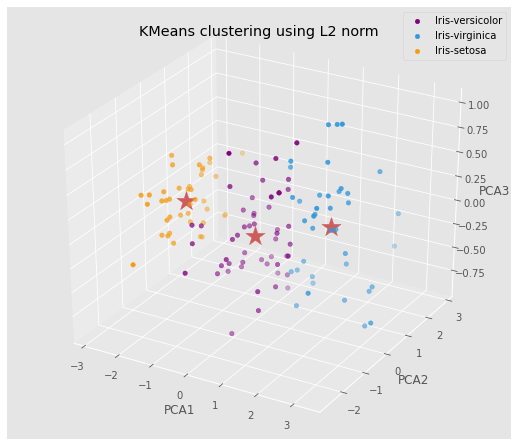

In [22]:
cluster_centers = kmeans_l2_pipeline['kmeans'].cluster_centers_
cluster_labels = kmeans_l2_pipeline['kmeans'].labels_

fig = plt.figure(figsize=(7, 6))
ax = Axes3D(fig)

xs = X_processed[:, 0]
ys = X_processed[:, 1]
zs = X_processed[:, 2]

for i in range(k):
    idx = cluster_labels==i
    color = color3c(np.unique(cluster_labels[idx]))
    class_label = cl_mapping[i]
    ax.scatter(xs[idx], ys[idx], zs[idx], marker='o', s=20, c=color, label=class_label)

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

ax.legend()

for center in cluster_centers:
    ax.scatter(*center, marker='*', s=400, c='indianred')

plt.title('KMeans clustering using L2 norm')
plt.savefig('output_plot_train_set_l2_norm.png')
plt.show()

### Use L1 Norm

In [23]:
from custom_kmeans import KMeans
kmeans = KMeans(n_clusters=k, init='random', norm_=1, tol=1e-4, random_state=42)
kmeans_l1_pipeline = Pipeline([
    ('preprocess', preprocessing_pipe),
    ('kmeans', kmeans)
])

In [24]:
X, y = iris.drop(iris.columns[-1], axis=1), iris[iris.columns[-1]]
kmeans_l1_pipeline.fit(X)

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('stdscaler', StandardScaler()),
                                 ('pca',
                                  PCA(n_components=3, random_state=42))])),
                ('kmeans', KMeans(n_clusters=3, norm_=1, random_state=42))])

In [25]:
X_processed = preprocessing_pipe.fit_transform(X)
l2_inertia = kmeans_l1_pipeline['kmeans'].distance_from_center(X_processed, norm_=2, squared=True)
predict_class, cl_mapping = kmeans_l1_pipeline['kmeans'].map_cluster_class(y)

print('KMeans results on training set with norm=L1')
print('_'*80)
print(f'Cluster Centers: ',kmeans_l1_pipeline['kmeans'].cluster_centers_)
print('-'*80)
print(f"Inertia (L2/L1): ({l2_inertia}/{kmeans_l1_pipeline['kmeans'].inertia_})")
print('-'*80)
print(f'Silhouette Score: ', silhouette_score(X_processed, kmeans_l1_pipeline['kmeans'].labels_))
print('-'*80)
print(f'Classification Accuracy Score: ', accuracy_score(y, list(predict_class)))
print('-'*80)

KMeans results on training set with norm=L1
________________________________________________________________________________
Cluster Centers:  [[ 0.51568971 -0.67866672  0.0393316 ]
 [ 1.85618665  0.68704068 -0.0122213 ]
 [-2.29972424  0.36614882 -0.04467613]]
--------------------------------------------------------------------------------
Inertia (L2/L1): (126.36273227575815/164.01464323344425)
--------------------------------------------------------------------------------
Silhouette Score:  0.4611412824263567
--------------------------------------------------------------------------------
Classification Accuracy Score:  0.8461538461538461
--------------------------------------------------------------------------------


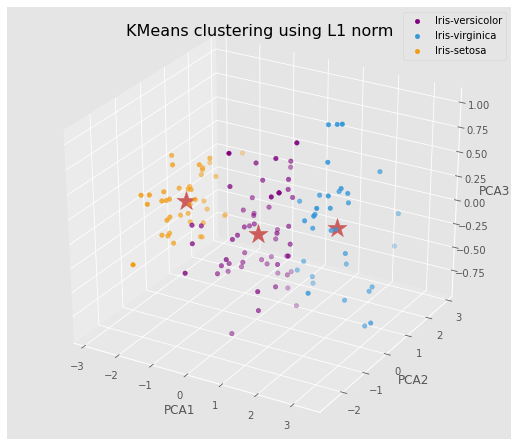

In [26]:
cluster_centers = kmeans_l1_pipeline['kmeans'].cluster_centers_
cluster_labels = kmeans_l1_pipeline['kmeans'].labels_

fig = plt.figure(figsize=(7, 6))
ax = Axes3D(fig)

X_processed = preprocessing_pipe.fit_transform(X)

xs = X_processed[:, 0]
ys = X_processed[:, 1]
zs = X_processed[:, 2]

for i in range(k):
    idx = cluster_labels==i
    color = color3c(np.unique(cluster_labels[idx]))
    class_label = cl_mapping[i]
    ax.scatter(xs[idx], ys[idx], zs[idx], marker='o', s=20, c=color, label=class_label)

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

ax.legend()

for center in cluster_centers:
    ax.scatter(*center, marker='*', s=400, c='indianred')

plt.title('KMeans clustering using L1 norm', fontsize=16)
plt.savefig('output_plot_train_set_l1_norm.png')
plt.show()

<a id='model_score'></a>
### Result of Training KMeans with L2 vs L1 Norms
- The higher Silhouette score (_`0.45626639088673554 vs 0.4611412824263567`_) demonstrates that clustering fits better when used L1 norm.
- The classification score using class labels provided in dataset (`_0.823076923076923 vs 0.8461538461538461_`) further strengthens the claim above that L1 norm makes cluster fit better.

### Write Train Classification Labels to CSV

In [27]:
clsf_iris_train = pd.concat((iris,
           pd.DataFrame(kmeans_l2_pipeline['kmeans'].map_cluster_class(y)[0],columns=['Classificaion Label L2']),
           pd.DataFrame(kmeans_l1_pipeline['kmeans'].map_cluster_class(y)[0],columns=['Classificaion Label L1'])
          ), axis=1)
clsf_iris_train

,0,1,2,3,4,Classificaion Label L2,Classificaion Label L1
0,7.2,3.2,6.0,1.8,Iris-virginica,Iris-virginica,Iris-virginica
1,6.3,3.3,4.7,1.6,Iris-versicolor,Iris-virginica,Iris-virginica
2,6.3,3.3,6.0,2.5,Iris-virginica,Iris-virginica,Iris-virginica
3,5.0,3.5,1.3,0.3,Iris-setosa,Iris-setosa,Iris-setosa
4,5.9,3.0,5.1,1.8,Iris-virginica,Iris-versicolor,Iris-versicolor
...,...,...,...,...,...,...,...
125,4.5,2.3,1.3,0.3,Iris-setosa,Iris-setosa,Iris-setosa
126,6.2,2.8,4.8,1.8,Iris-virginica,Iris-versicolor,Iris-versicolor
127,5.8,2.7,4.1,1.0,Iris-versicolor,Iris-versicolor,Iris-versicolor
128,5.0,3.4,1.6,0.4,Iris-setosa,Iris-setosa,Iris-setosa


In [28]:
clsf_iris_train.to_csv(CLASSIFICATION_TRAIN_CSV, index=False)

## Hyperparameter Tuning

#### Tunable Custom K-Means Hyperparameters
- __n_clusters__: number of clusters to form
- __tol__: tolerance (_error_) allowed before convergance
- __init__: initialization method for locating initial centroids, `allowed ['random', 'pca']`
- __norm___: distance metric used to measure distance of points from centers, `allowed [1, 2]; corresponds to [L1, L2] norm/ [Manhattan, Euclidean]`
- __max_iter__: max number of iterations to run before converge
- __n_init__: number of jobs/ initializations to run `when used init='random'`

### Elbow Method to find `n_clusters`

In [29]:
X, y = iris.drop(iris.columns[-1], axis=1), iris[iris.columns[-1]]

In [30]:
X_processed = preprocessing_pipe.fit_transform(X)

In [31]:
from custom_kmeans import KMeans

km_scores = []
km_silhouette = []

for i in range(2, 8):
    kmeans = KMeans(n_clusters=i, init='random', norm_=1, tol=1e-4, random_state=42).fit(X_processed)
    labels = kmeans.labels_
    
    km_scores.append(kmeans.inertia_)
    silhouette = silhouette_score(X_processed, labels)
    km_silhouette.append(silhouette)

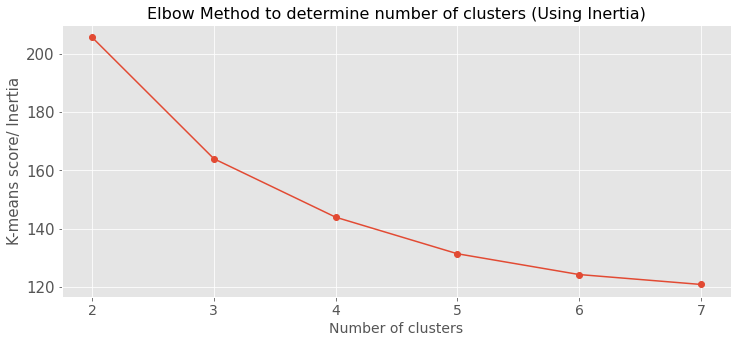

In [32]:
plt.figure(figsize=(12,5))
plt.title("Elbow Method to determine number of clusters (Using Inertia)",fontsize=16)
plt.plot([i for i in range(2,8)],km_scores, marker = 'o')
plt.grid(True)

plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("K-means score/ Inertia",fontsize=15)
plt.xticks([i for i in range(2,8)],fontsize=14)
plt.yticks(fontsize=15)
plt.savefig('output_the_elbow_method_inertia.png')
plt.show()

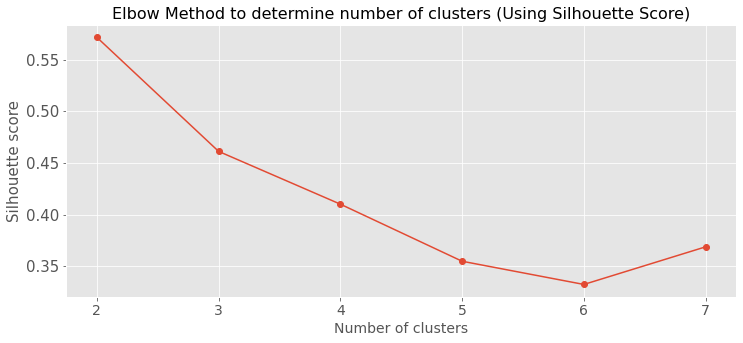

In [33]:
plt.figure(figsize=(12,5))
plt.title("Elbow Method to determine number of clusters (Using Silhouette Score)",fontsize=16)
plt.plot([i for i in range(2,8)],km_silhouette, marker = 'o')
plt.grid(True)

plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,8)],fontsize=14)
plt.yticks(fontsize=15)
plt.savefig('output_the_elbow_method_silhouette.png')
plt.show()

#### Deductions
- Using Inertia curve, the optimal value of k (_number of clusters_) could be one of [3,4,5], (_lower values are preferred_).
- Using Silhouette curve, the optimal value of k would be again [3,4,5], (_higher values are preferred_)
- We can assume here optimal value of k to be 3, (_provided knowledge of dataset classes_), futher look as GridSearch for parameter tuning.


### Grid Search to find best `hyperparameter` values

In [34]:
X, y = iris.drop(iris.columns[-1], axis=1), iris[iris.columns[-1]]

In [35]:
def cv_silhouette_scorer(estimator, X):
    estimator.fit(X)
    labels = estimator['kmeans'].labels_
    return silhouette_score(X, labels)

km_pipeline = Pipeline([
    ('preprocess', preprocessing_pipe),
    ('kmeans', KMeans(init='random', random_state=42))
])

In [36]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'kmeans__n_clusters': [3,4,5], 'kmeans__norm_': [1,2], 'kmeans__init': ['random'],
     'kmeans__tol': [1e-2, 1e-3, 1e-4], 'kmeans__max_iter': [50, 100, 200],
     'preprocess__pca__n_components': [2,3,4], 'preprocess__imputer__strategy': ['mean', 'median']},
    {'kmeans__n_clusters': [3,4], 'kmeans__norm_': [1,2], 'kmeans__init': ['pca'],
     'kmeans__tol': [1e-2, 1e-3, 1e-4], 'kmeans__max_iter': [50, 100, 200],
    'preprocess__pca__n_components': [4], 'preprocess__imputer__strategy': ['mean', 'median']}
]

cv = [(slice(None), slice(None))]
gs = GridSearchCV(estimator=km_pipeline, param_grid=param_grid, 
                  scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1).fit(X)


In [37]:
best_model = gs.best_estimator_
best_model

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('stdscaler', StandardScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('kmeans',
                 KMeans(max_iter=50, n_clusters=3, norm_=1, random_state=42,
                        tol=0.01))])

In [38]:
predict_class, _ = best_model['kmeans'].map_cluster_class(y)
X_processed = best_model['preprocess'].fit_transform(X)

print('KMeans results on training set with Grid Search/Hyperparameter Tuning')
print('-'*80)
print(f'Silhouette Score: ', silhouette_score(X_processed, best_model['kmeans'].labels_))
print('-'*80)
print(f'Classification Accuracy Score: ', accuracy_score(y, list(predict_class)))


KMeans results on training set with Grid Search/Hyperparameter Tuning
--------------------------------------------------------------------------------
Silhouette Score:  0.5044026541791246
--------------------------------------------------------------------------------
Classification Accuracy Score:  0.8461538461538461


### Deductions
- __preprocess__
    - __pca__: Tuned parameter `n_components=2`, shows that dimensionality reduction benefits.
- __kmeans__
    - `n_clusters=3`
    - `norm_=1`
    - `tol=0.01`
- __Silhouette Score__ has improved, earlier best score was `0.4611412824263567` (using [L1 norm](#Use-L1-Norm))
- Note: `Accuracy Score is same as model trained with L1 norm.`

## Test Model

In [39]:
iris_test = pd.read_csv('./iris_test.csv', names=list(range(dimension + 1)), header=None)

In [40]:
X_test, y_test = iris_test.drop(dimension, axis=1), iris_test[dimension]

In [41]:
predicted_labels = best_model.predict(X_test)
predicted_labels

array([2, 1, 2, 0, 1, 2, 2, 2, 0, 2, 2, 0, 1, 1, 0, 2, 2, 1, 1, 2])

In [42]:
_, cluster_class_mapping = best_model['kmeans'].map_cluster_class(y)
cluster_class_mapping

{2: 'Iris-setosa', 0: 'Iris-versicolor', 1: 'Iris-virginica'}

In [43]:
predicted_class = list(map(lambda x: cluster_class_mapping[x], predicted_labels))
predicted_class

['Iris-setosa',
 'Iris-virginica',
 'Iris-setosa',
 'Iris-versicolor',
 'Iris-virginica',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-versicolor',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-versicolor',
 'Iris-virginica',
 'Iris-virginica',
 'Iris-versicolor',
 'Iris-setosa',
 'Iris-setosa',
 'Iris-virginica',
 'Iris-virginica',
 'Iris-setosa']

In [44]:
print(f'Classification Accuracy Score: ', accuracy_score(y_test, list(predicted_class)))

Classification Accuracy Score:  0.9


## Explanation
- Predict the cluster labels (_assignment of cluster_) on test data.
- Collect the mapping (`cluster_label:cluster_class`) from trained model.
- `The best model classifies test data with accuracy of 90%`.

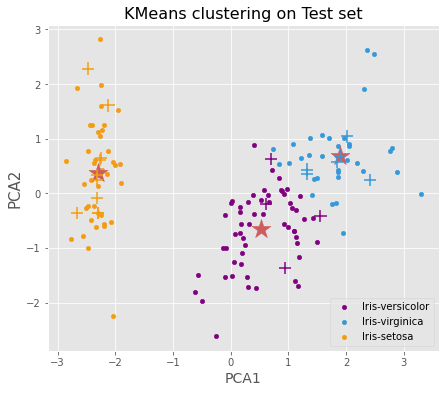

In [45]:
cluster_centers = best_model['kmeans'].cluster_centers_
cluster_labels = best_model['kmeans'].labels_
fig = plt.figure(figsize=(7, 6))

X_processed = best_model['preprocess'].fit_transform(X)

xs = X_processed[:, 0]
ys = X_processed[:, 1]

for i in range(k):
    idx = cluster_labels==i
    color = color3c(np.unique(cluster_labels[idx]))
    class_label = cluster_class_mapping[i]
    plt.scatter(xs[idx], ys[idx], marker='o', s=20, c=color, label=class_label)


plt.xlabel('PCA1',fontsize=14)
plt.ylabel('PCA2',fontsize=15)

for center in cluster_centers:
    plt.scatter(*center, marker='*', s=400, c='indianred')

plt.legend()

X_test_transform = best_model['preprocess'].transform(X_test)

plt.scatter(X_test_transform[:, 0], X_test_transform[:, 1], marker='+', s=150, c=color3c(predicted_labels))
plt.title('KMeans clustering on Test set', fontsize=16)
plt.savefig('output_scatter_plot_test_data.png')
plt.show()

### Write Test Classification Labels to CSV

In [46]:
clsf_iris_test = pd.concat((iris_test,
           pd.DataFrame(predicted_class,columns=['Classificaion Label']),
          ), axis=1)
clsf_iris_test.to_csv(CLASSIFICATION_TEST_CSV, index=False)
clsf_iris_test

,0,1,2,3,4,Classificaion Label
0,4.8,3.4,1.9,0.2,Iris-setosa,Iris-setosa
1,6.4,3.1,5.5,1.8,Iris-virginica,Iris-virginica
2,5.4,3.9,1.7,0.4,Iris-setosa,Iris-setosa
3,6.4,2.7,5.3,1.9,Iris-virginica,Iris-versicolor
4,7.4,2.8,6.1,1.9,Iris-virginica,Iris-virginica
5,4.9,3.1,1.5,0.1,Iris-setosa,Iris-setosa
6,5.1,3.5,1.4,0.3,Iris-setosa,Iris-setosa
7,4.9,3.1,1.5,0.1,Iris-setosa,Iris-setosa
8,6.3,2.3,4.4,1.3,Iris-versicolor,Iris-versicolor
9,5.0,3.4,1.5,0.2,Iris-setosa,Iris-setosa


## Flexibility of Custom KMeans

- Custom KMeans test on dataset of shape `(1797, 64)`
- Also, output the same performance metrics as on iris dataset

In [47]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from custom_kmeans import KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.pipeline import Pipeline
import numpy as np

In [48]:
X_digits, y_digits = load_digits(return_X_y=True)

In [49]:
X_digits.shape

(1797, 64)

In [50]:
np.unique(y_digits)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [51]:
def cv_silhouette_scorer(estimator, X):
    estimator.fit(X)
    labels = estimator['kmeans'].labels_
    return silhouette_score(X, labels)

In [52]:
digits_preprocess = Pipeline([
    ('scale', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('pca', PCA(random_state=42)),
])

digits_pipe = Pipeline([
    ('preprocess', digits_preprocess),
    ('kmeans', KMeans(init='pca', random_state=42))
])

In [53]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'kmeans__n_clusters': [8,9,10], 'kmeans__norm_': [1,2], 'kmeans__init': ['random'],
     'kmeans__tol': [1e-2, 1e-3, 1e-4], 'kmeans__max_iter': [200, 300, 350],
     'preprocess__imputer__strategy': ['mean', 'median']},
    {'kmeans__n_clusters': [3,4,5], 'kmeans__norm_': [1,2], 'kmeans__init': ['pca'],
     'kmeans__tol': [1e-2, 1e-3, 1e-4], 'kmeans__max_iter': [50, 100, 200],
    'preprocess__pca__n_components': [10], 'preprocess__imputer__strategy': ['mean', 'median']}
]

cv = [(slice(None), slice(None))]
gs = GridSearchCV(estimator=digits_pipe, param_grid=param_grid, 
                  scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1).fit(X_digits)

In [54]:
digits_model = gs.best_estimator_
digits_model

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('scale', StandardScaler()),
                                 ('imputer', SimpleImputer()),
                                 ('pca', PCA(random_state=42))])),
                ('kmeans',
                 KMeans(max_iter=200, n_clusters=10, norm_=1, random_state=42,
                        tol=0.01))])

In [56]:
dx_processed = digits_preprocess.fit_transform(X_digits)
predict_class, cl_mapping = digits_model['kmeans'].map_cluster_class(y_digits)

print('KMeans results on digits dataset')
print('-'*80)
print(f"Inertia: {digits_model['kmeans'].inertia_}")
print('-'*80)
print(f'Silhouette Score: ', silhouette_score(dx_processed, digits_model['kmeans'].labels_))
print('-'*80)
print(f'Classification Accuracy Score: ', accuracy_score(y_digits, list(predict_class)))
print('-'*80)

KMeans results on digits dataset
--------------------------------------------------------------------------------
Inertia: 56996.77431666977
--------------------------------------------------------------------------------
Silhouette Score:  0.1390819261362174
--------------------------------------------------------------------------------
Classification Accuracy Score:  0.6466332776850306
--------------------------------------------------------------------------------
